<a href="https://colab.research.google.com/github/CidClayQuirino/WarrantyCostBySMRBomFuturo/blob/main/Proj_Custo_Garantia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1192538506.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(["SMR_BIN", "MODEL"], dropna=False)["AMOUNT"].sum().reset_index()


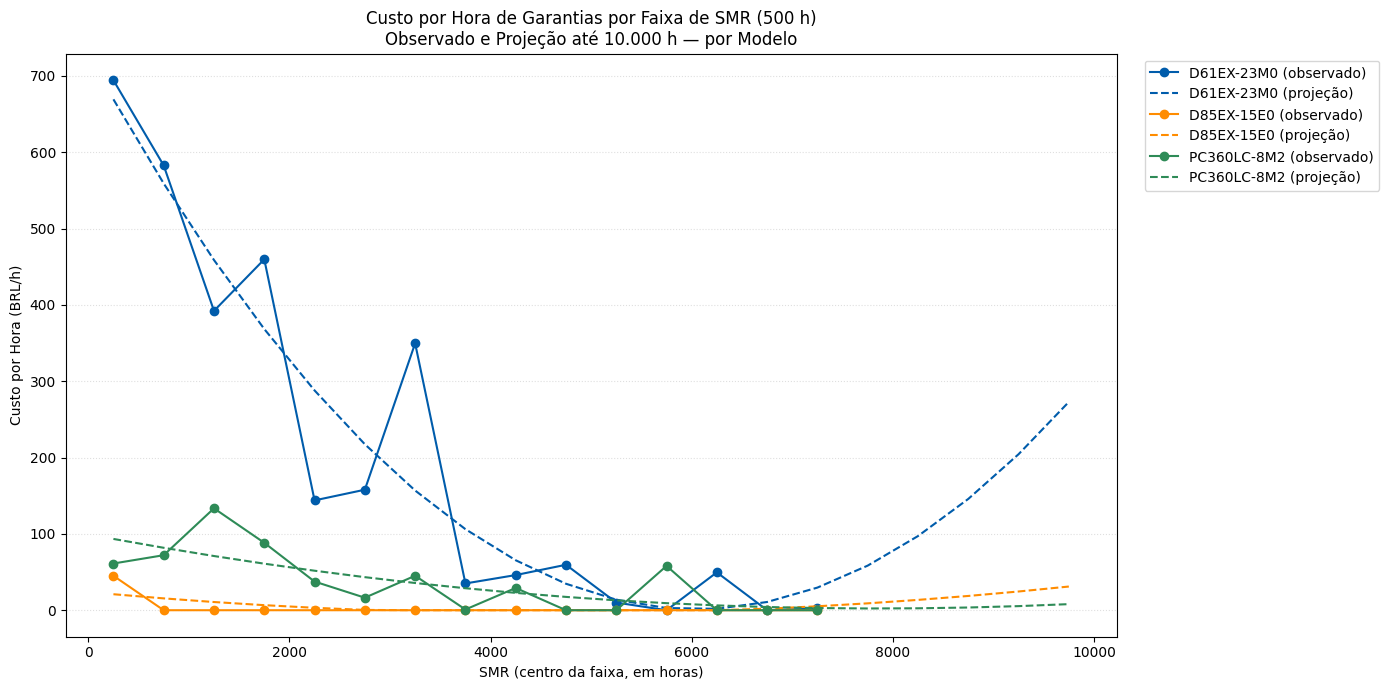

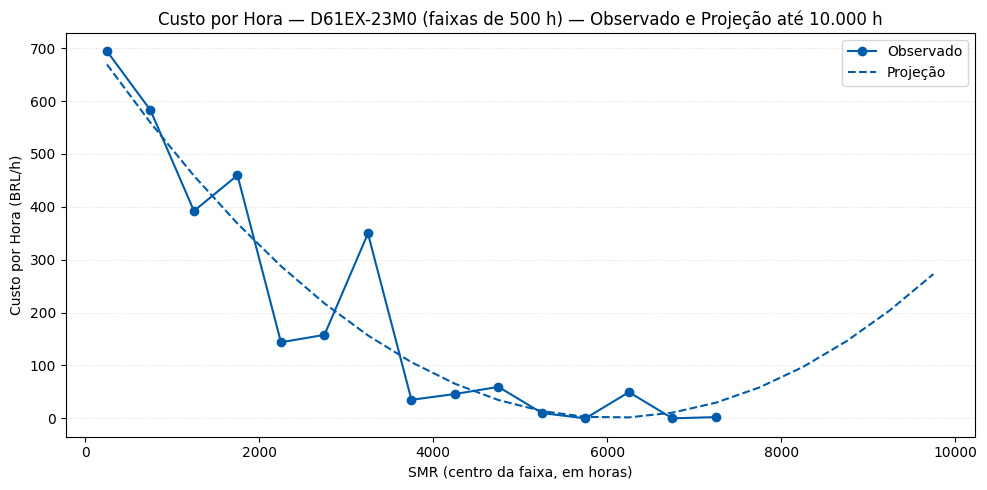

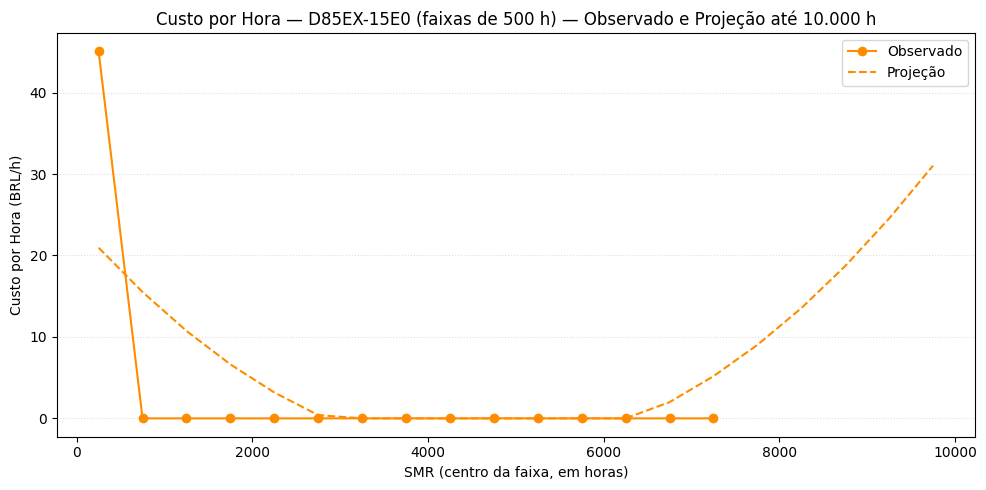

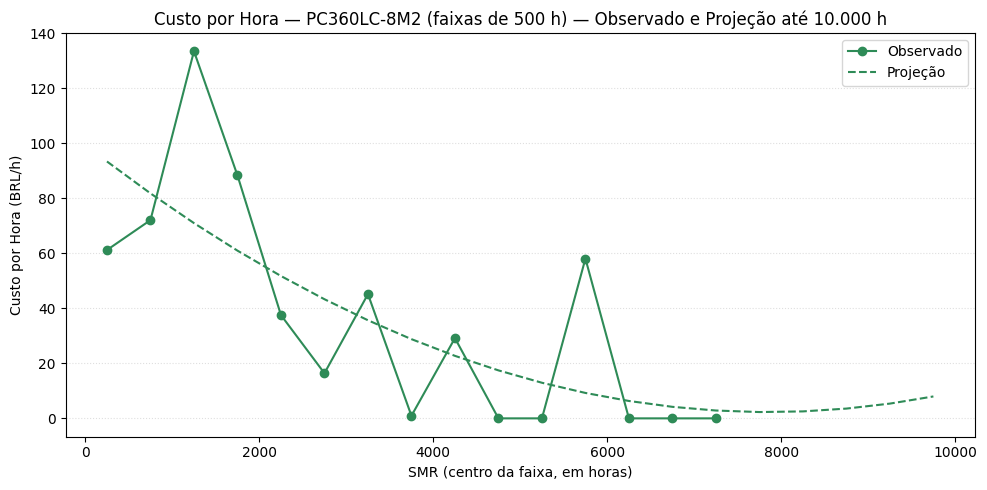

In [2]:

# -*- coding: utf-8 -*-
# Google Colab: cálculo de Custo por Hora de garantias por faixas de SMR (500 h)
# + Projeção da curva até 10.000 h, separado por modelo

# 1) Dependências
!pip -q install openpyxl

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# 2) Fonte de dados (RAW do GitHub)
RAW_URL = "https://raw.githubusercontent.com/CidClayQuirino/WarrantyCostBySMRBomFuturo/2f256b5c40ae944427c31e37c4e530497f38e22a/PC360LC_D85_D61.xlsx"

# 3) Leitura do Excel
df = pd.read_excel(RAW_URL, engine="openpyxl")

# 4) Padronização de nomes de coluna (MODEL, SMR, AMOUNT)
#    Fallback para nomes usados na sua planilha original (MCN_COMPLETE_MODEL, MCN_FAILURE_SMR, BASE_DEC_TOTAL_AMOUNT)
col_map_candidates = [
    {"MODEL": "MODEL", "SMR": "SMR", "AMOUNT": "AMOUNT"},
    {"MODEL": "MCN_COMPLETE_MODEL", "SMR": "MCN_FAILURE_SMR", "AMOUNT": "BASE_DEC_TOTAL_AMOUNT"}
]

def standardize_columns(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        ok = True
        resolved = {}
        for k, v in cand.items():
            if v in df.columns:
                resolved[k] = v
            elif v.lower() in cols_lower:
                resolved[k] = cols_lower[v.lower()]
            else:
                ok = False
                break
        if ok:
            return df[[resolved["MODEL"], resolved["SMR"], resolved["AMOUNT"]]].rename(
                columns={resolved["MODEL"]: "MODEL", resolved["SMR"]: "SMR", resolved["AMOUNT"]: "AMOUNT"}
            )
    raise ValueError("Não foi possível localizar colunas MODEL/SMR/AMOUNT (ou equivalentes).")

df = standardize_columns(df, col_map_candidates)

# 5) Limpeza de tipos
df["MODEL"] = df["MODEL"].astype(str)
df["SMR"] = pd.to_numeric(df["SMR"], errors="coerce")
df["AMOUNT"] = pd.to_numeric(df["AMOUNT"], errors="coerce").fillna(0)

# Remove registros sem SMR
df = df.dropna(subset=["SMR"]).copy()

# 6) Parâmetros
BIN_SIZE = 500  # tamanho das faixas

# 7) Construção das faixas até o SMR máximo observado
max_smr_observado = int(np.nanmax(df["SMR"]))
max_edge = int(math.ceil(max_smr_observado / BIN_SIZE) * BIN_SIZE)
bins = np.arange(0, max_edge + BIN_SIZE, BIN_SIZE)
labels = [f"{int(bins[i])}–{int(bins[i+1]-1)}" for i in range(len(bins)-1)]

# 8) Atribuição de faixa
df["SMR_BIN"] = pd.cut(df["SMR"], bins=bins, right=False, labels=labels)

# 9) Agregação por faixa e modelo
grp = df.groupby(["SMR_BIN", "MODEL"], dropna=False)["AMOUNT"].sum().reset_index()

# Custo/hora por faixa = total da faixa / 500 h
grp["CUSTO_POR_HORA"] = grp["AMOUNT"] / BIN_SIZE

# 10) Pivot para gráficos (faixa × modelo)
pivot_cph = grp.pivot(index="SMR_BIN", columns="MODEL", values="CUSTO_POR_HORA").fillna(0)
pivot_cph = pivot_cph.reindex(labels)

# 11) Projeção até 10.000 h por modelo (polinômio grau 2, com fallbacks)
def faixa_centers(labels):
    centers = []
    for lab in labels:
        a, b = lab.split("–")
        a, b = int(a), int(b)
        centers.append((a + b) / 2.0)
    return np.array(centers)

centers_observados = faixa_centers(labels)

bins_proj = np.arange(0, 10000 + BIN_SIZE, BIN_SIZE)
labels_proj = [f"{int(bins_proj[i])}–{int(bins_proj[i+1]-1)}" for i in range(len(bins_proj)-1)]
centers_proj = faixa_centers(labels_proj)

def prever_por_modelo(y_obs, x_obs, x_proj):
    y = np.array(y_obs, dtype=float)
    x = np.array(x_obs, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if len(x) == 0:
        return np.zeros_like(x_proj, dtype=float)
    if len(x) == 1:
        yhat = np.full_like(x_proj, y[0], dtype=float)
    elif len(x) == 2:
        coef = np.polyfit(x, y, deg=1)
        yhat = np.polyval(coef, x_proj)
    else:
        coef = np.polyfit(x, y, deg=2)
        yhat = np.polyval(coef, x_proj)
    return np.maximum(yhat, 0.0)

proj_dict = {}
for modelo in pivot_cph.columns:
    y_obs = pivot_cph[modelo].values
    x_obs = centers_observados[:len(y_obs)]
    proj_dict[modelo] = prever_por_modelo(y_obs, x_obs, centers_proj)

df_proj = pd.DataFrame(proj_dict, index=labels_proj)
df_proj.index.name = "SMR_BIN"

# 12) Exports
pivot_cph.to_csv("custo_por_hora_por_modelo_por_faixa_500h.csv")
df_proj.to_csv("projecao_custo_por_hora_ate_10000h_por_modelo.csv")

# 13) Gráfico consolidado: Observado + Projeção
plt.figure(figsize=(14, 7))
colors = ['#005CAB', '#FF8C00', '#2E8B57', '#8A2BE2', '#DC143C', '#1E90FF', '#708090', '#20B2AA']

for i, modelo in enumerate(pivot_cph.columns):
    y_obs = pivot_cph[modelo].values
    x_obs = centers_observados[:len(y_obs)]
    plt.plot(x_obs, y_obs, marker='o', linestyle='-', color=colors[i % len(colors)], label=f"{modelo} (observado)")
    yhat = df_proj[modelo].values
    plt.plot(centers_proj, yhat, linestyle='--', color=colors[i % len(colors)], label=f"{modelo} (projeção)")

plt.title("Custo por Hora de Garantias por Faixa de SMR (500 h)\nObservado e Projeção até 10.000 h — por Modelo")
plt.xlabel("SMR (centro da faixa, em horas)")
plt.ylabel("Custo por Hora (BRL/h)")
plt.grid(True, axis='y', linestyle=':', alpha=0.4)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig("custo_por_hora_por_modelo_observado_e_projecao.png", dpi=150)
plt.show()

# 14) Um gráfico por modelo (cada PNG separado)
for i, modelo in enumerate(pivot_cph.columns):
    plt.figure(figsize=(10, 5))
    y_obs = pivot_cph[modelo].values
    x_obs = centers_observados[:len(y_obs)]
    yhat = df_proj[modelo].values

    plt.plot(x_obs, y_obs, marker='o', linestyle='-', color=colors[i % len(colors)], label="Observado")
    plt.plot(centers_proj, yhat, linestyle='--', color=colors[i % len(colors)], label="Projeção")
    plt.title(f"Custo por Hora — {modelo} (faixas de 500 h) — Observado e Projeção até 10.000 h")
    plt.xlabel("SMR (centro da faixa, em horas)")
    plt.ylabel("Custo por Hora (BRL/h)")
    plt.grid(True, axis='y', linestyle=':', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    # >>> Linha corrigida aqui <<<
    plt.savefig(f"custo_por_hora_{modelo.replace('/', '_').replace(' ', '_')}.png", dpi=150)
    plt.show()


/tmp/ipython-input-3920140696.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp_amt = df.groupby(["SMR_BIN", "MODEL"], dropna=False)["AMOUNT"].sum().reset_index()


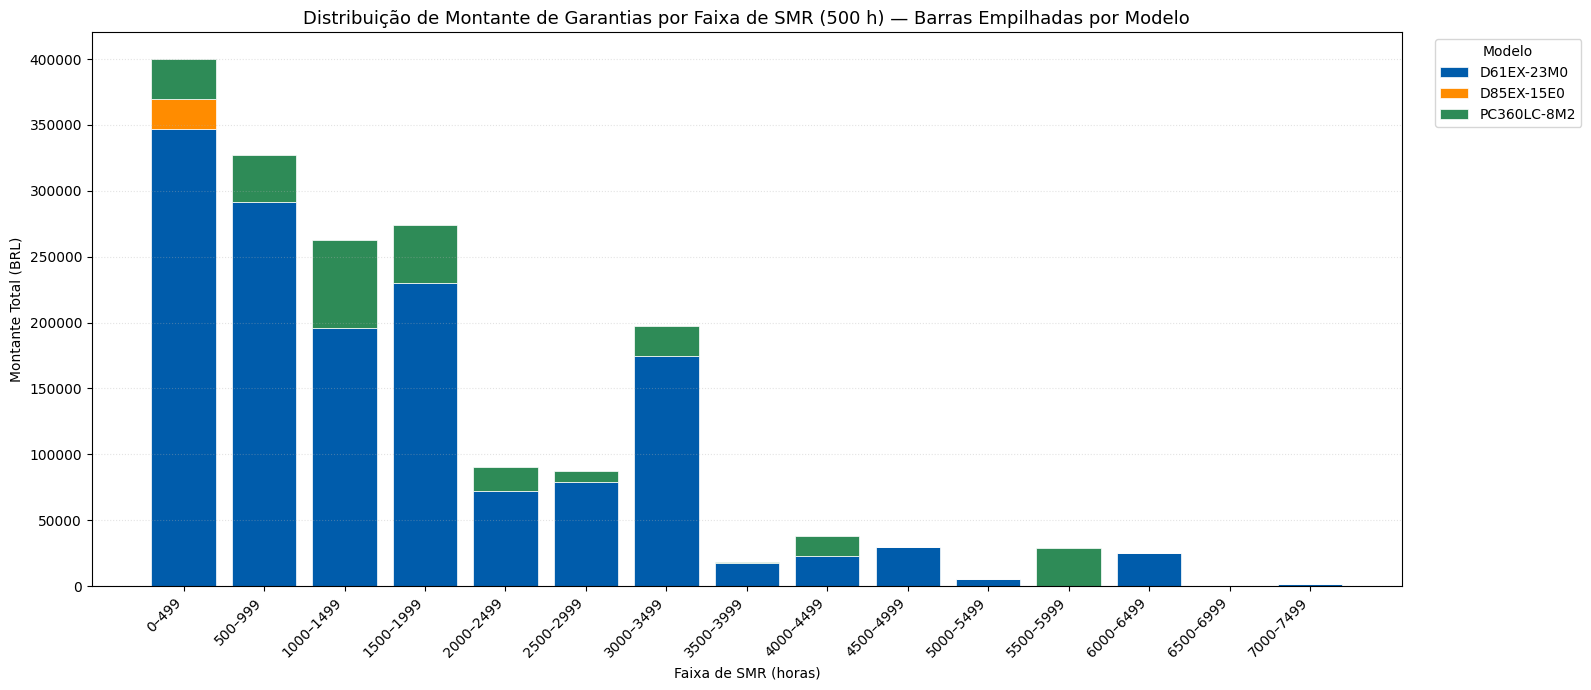

Arquivos gerados:
- montante_total_empilhado_por_modelo_por_faixa_500h.png


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [8]:

# -*- coding: utf-8 -*-
# Google Colab: gráfico de colunas empilhadas (montante total) por faixas de SMR (500 h) × modelo

# 1) Dependências
!pip -q install openpyxl

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# 2) Fonte de dados (RAW do GitHub)
RAW_URL = "https://raw.githubusercontent.com/CidClayQuirino/WarrantyCostBySMRBomFuturo/2f256b5c40ae944427c31e37c4e530497f38e22a/PC360LC_D85_D61.xlsx"

# 3) Leitura do Excel
df = pd.read_excel(RAW_URL, engine="openpyxl")

# 4) Padronização de nomes (MODEL, SMR, AMOUNT) com fallback
col_map_candidates = [
    {"MODEL": "MODEL", "SMR": "SMR", "AMOUNT": "AMOUNT"},
    {"MODEL": "MCN_COMPLETE_MODEL", "SMR": "MCN_FAILURE_SMR", "AMOUNT": "BASE_DEC_TOTAL_AMOUNT"}
]

def standardize_columns(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        ok = True
        resolved = {}
        for k, v in cand.items():
            if v in df.columns:
                resolved[k] = v
            elif v.lower() in cols_lower:
                resolved[k] = cols_lower[v.lower()]
            else:
                ok = False
                break
        if ok:
            return df[[resolved["MODEL"], resolved["SMR"], resolved["AMOUNT"]]].rename(
                columns={resolved["MODEL"]: "MODEL", resolved["SMR"]: "SMR", resolved["AMOUNT"]: "AMOUNT"}
            )
    raise ValueError("Não foi possível localizar colunas MODEL/SMR/AMOUNT (ou equivalentes).")

df = standardize_columns(df, col_map_candidates)

# 5) Limpeza de tipos
df["MODEL"] = df["MODEL"].astype(str)
df["SMR"] = pd.to_numeric(df["SMR"], errors="coerce")
df["AMOUNT"] = pd.to_numeric(df["AMOUNT"], errors="coerce").fillna(0)

# Remove registros sem SMR
df = df.dropna(subset=["SMR"]).copy()

# 6) Construção das faixas de 500 h até o máximo observado
BIN_SIZE = 500
max_smr = int(np.nanmax(df["SMR"]))
max_edge = int(math.ceil(max_smr / BIN_SIZE) * BIN_SIZE)

bins = np.arange(0, max_edge + BIN_SIZE, BIN_SIZE)       # 0, 500, 1000, ...
labels = [f"{int(bins[i])}–{int(bins[i+1]-1)}" for i in range(len(bins)-1)]

# 7) Atribuir cada registro a uma faixa
df["SMR_BIN"] = pd.cut(df["SMR"], bins=bins, right=False, labels=labels)

# 8) Agregar montante total por faixa × modelo
grp_amt = df.groupby(["SMR_BIN", "MODEL"], dropna=False)["AMOUNT"].sum().reset_index()

# 9) Pivot para gráfico empilhado (linhas = faixas, colunas = modelos)
pivot_amt = grp_amt.pivot(index="SMR_BIN", columns="MODEL", values="AMOUNT").fillna(0)
pivot_amt = pivot_amt.reindex(labels)  # garantir ordem das faixas

# 10) (Opcional) rótulos de valor total por coluna no topo
def add_total_labels(x_labels, matrix):
    totals = matrix.sum(axis=1).values
    for xi, total in enumerate(totals):
        plt.text(xi, total, f"{total:,.0f}", ha="center", va="bottom", fontsize=9)

# 11) Gráfico de colunas empilhadas (montante total por faixa × modelo)
plt.figure(figsize=(16, 7))
colors = ['#005CAB','#FF8C00','#2E8B57','#8A2BE2','#DC143C','#1E90FF','#708090','#20B2AA','#8B4513','#FF1493']

x = pivot_amt.index.astype(str)
bottom = np.zeros(len(pivot_amt), dtype=float)

for i, col in enumerate(pivot_amt.columns):
    y = pivot_amt[col].values
    plt.bar(x, y, bottom=bottom, label=col, color=colors[i % len(colors)], edgecolor='white', linewidth=0.5)
    bottom += y

plt.xticks(rotation=45, ha='right')
plt.title("Distribuição de Montante de Garantias por Faixa de SMR (500 h) — Barras Empilhadas por Modelo", fontsize=13)
plt.xlabel("Faixa de SMR (horas)")
plt.ylabel("Montante Total (BRL)")
plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis='y', linestyle=':', alpha=0.35)

# (Opcional) rótulos com total no topo de cada barra
# add_total_labels(x, pivot_amt)

plt.tight_layout()
plt.savefig("montante_total_empilhado_por_modelo_por_faixa_500h.png", dpi=150)
plt.show()

# 12) Exportar a matriz (para auditoria/slide/tabela)
pivot_amt.to_csv("montante_total_por_faixa_500h_por_modelo.csv")

print("Arquivos gerados:")
print("- montante_total_empilhado_por_modelo_por_faixa_500h.png")
print



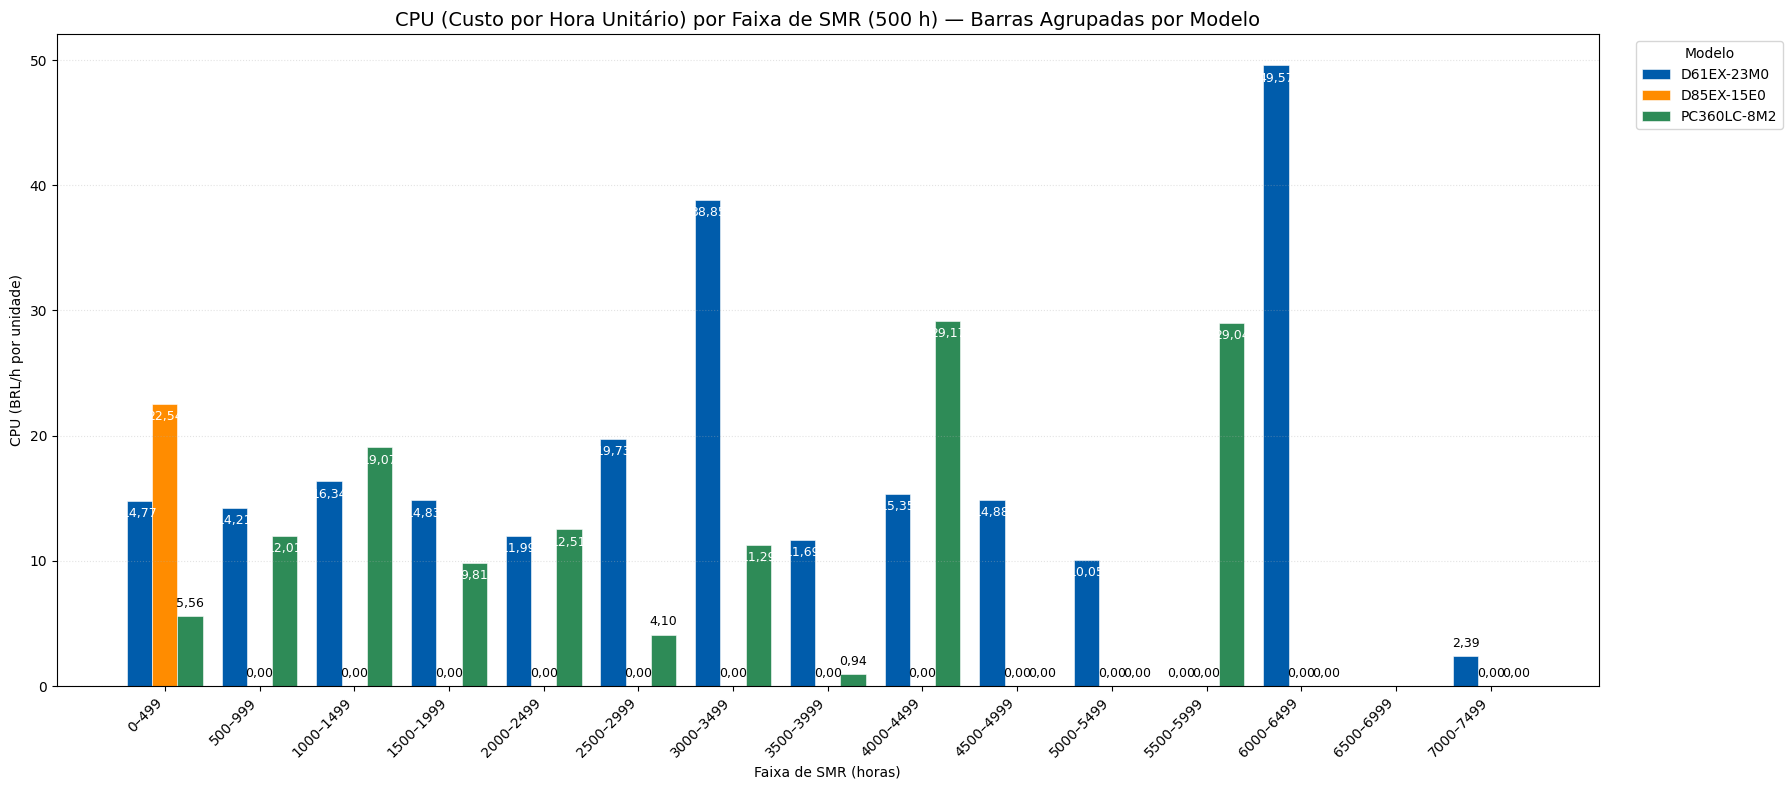

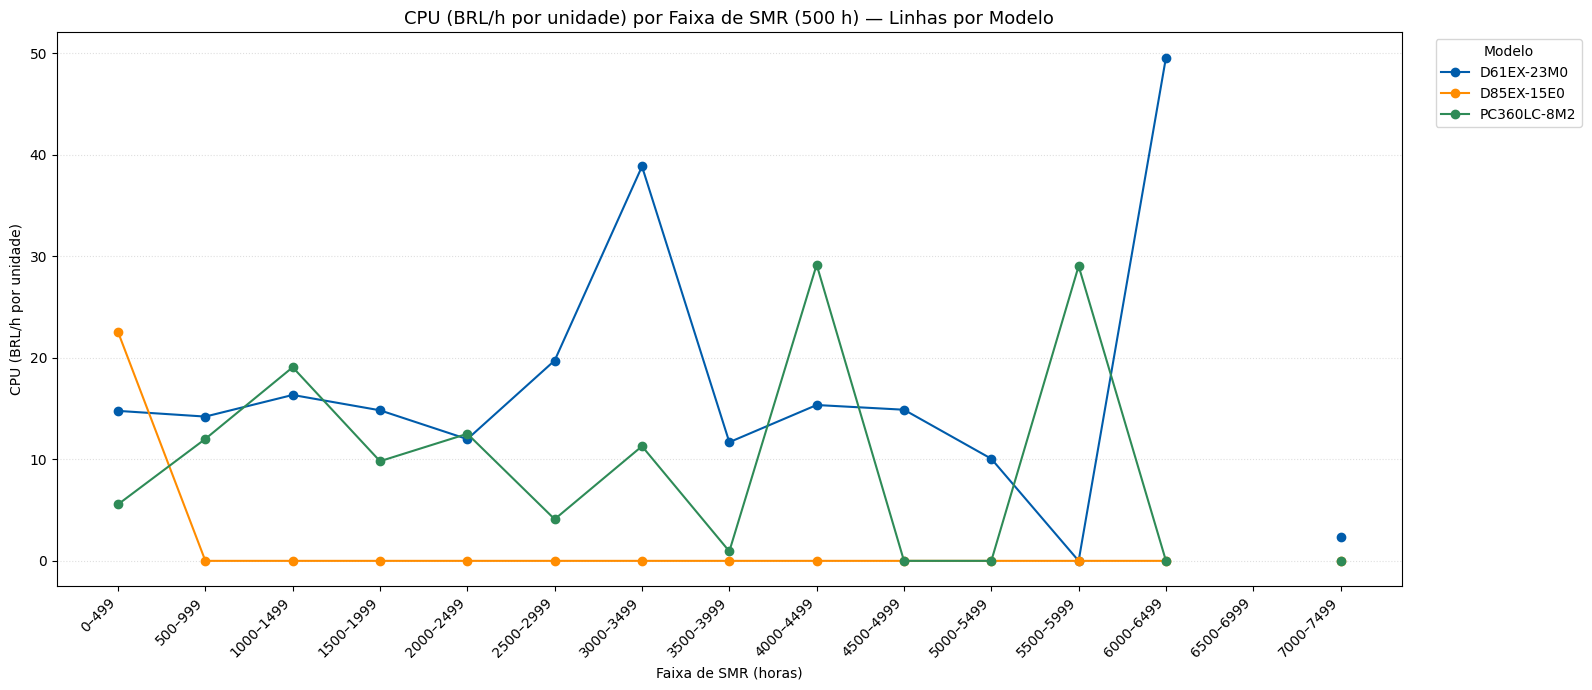

Arquivos gerados:
- cpu_por_faixa_500h_barras_agrupadas_por_modelo.png


NameError: name 'printprint' is not defined

In [21]:

# -*- coding: utf-8 -*-
# Google Colab: CPU (Custo por Hora Unitário) por faixas de SMR (500 h) × modelo
# CPU = Montante / (nº de máquinas únicas na faixa/modelo) / 500 h

# 1) Dependências
!pip -q install openpyxl

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# 2) Fonte de dados (RAW do GitHub)
RAW_URL = "https://raw.githubusercontent.com/CidClayQuirino/WarrantyCostBySMRBomFuturo/2f256b5c40ae944427c31e37c4e530497f38e22a/PC360LC_D85_D61.xlsx"

# 3) Leitura do Excel
df = pd.read_excel(RAW_URL, engine="openpyxl")

# 4) Padronização de nomes (MODEL, SMR, AMOUNT, MCN_SERIAL) com fallback
col_map_candidates = [
    {"MODEL": "MODEL", "SMR": "SMR", "AMOUNT": "AMOUNT", "MCN_SERIAL": "MCN_SERIAL"},
    {"MODEL": "MCN_COMPLETE_MODEL", "SMR": "MCN_FAILURE_SMR", "AMOUNT": "BASE_DEC_TOTAL_AMOUNT", "MCN_SERIAL": "MCN_SERIAL"}
]

def standardize_columns(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        ok = True
        resolved = {}
        for k, v in cand.items():
            if v in df.columns:
                resolved[k] = v
            elif v.lower() in cols_lower:
                resolved[k] = cols_lower[v.lower()]
            else:
                ok = False
                break
        if ok:
            return df[[resolved["MODEL"], resolved["SMR"], resolved["AMOUNT"], resolved["MCN_SERIAL"]]].rename(
                columns={
                    resolved["MODEL"]: "MODEL",
                    resolved["SMR"]: "SMR",
                    resolved["AMOUNT"]: "AMOUNT",
                    resolved["MCN_SERIAL"]: "MCN_SERIAL"
                }
            )
    raise ValueError("Não foi possível localizar colunas MODEL/SMR/AMOUNT/MCN_SERIAL (ou equivalentes).")

df = standardize_columns(df, col_map_candidates)

# 5) Limpeza de tipos
df["MODEL"] = df["MODEL"].astype(str)
df["MCN_SERIAL"] = df["MCN_SERIAL"].astype(str)
df["SMR"] = pd.to_numeric(df["SMR"], errors="coerce")
df["AMOUNT"] = pd.to_numeric(df["AMOUNT"], errors="coerce").fillna(0)

# Remove registros sem SMR
df = df.dropna(subset=["SMR"]).copy()

# 6) Construção das faixas de 500 h até o máximo observado
BIN_SIZE = 500
max_smr = int(np.nanmax(df["SMR"]))
max_edge = int(math.ceil(max_smr / BIN_SIZE) * BIN_SIZE)

bins = np.arange(0, max_edge + BIN_SIZE, BIN_SIZE)       # 0, 500, 1000, ...
labels = [f"{int(bins[i])}–{int(bins[i+1]-1)}" for i in range(len(bins)-1)]

# 7) Atribuir cada registro a uma faixa (categórico com labels)
df["SMR_BIN"] = pd.cut(df["SMR"], bins=bins, right=False, labels=labels)

# 8) Agregar montante total e contar máquinas únicas por faixa × modelo
#    observed=True (silencia FutureWarning e usa apenas grupos observados)
agg_amt = (
    df.groupby(["SMR_BIN", "MODEL"], observed=True, dropna=False)["AMOUNT"]
      .sum()
      .reset_index(name="AMOUNT_SUM")
)
agg_cnt = (
    df.groupby(["SMR_BIN", "MODEL"], observed=True, dropna=False)["MCN_SERIAL"]
      .nunique()
      .reset_index(name="UNIQUE_UNITS")
)

# 9) Merge e cálculo do CPU = AMOUNT_SUM / UNIQUE_UNITS / 500 h
cpu = pd.merge(agg_amt, agg_cnt, on=["SMR_BIN", "MODEL"], how="outer")

# >>> NÃO usar .fillna(0) no DataFrame inteiro (quebraria o categórico SMR_BIN)
# Preencher apenas colunas numéricas:
for col in ["AMOUNT_SUM", "UNIQUE_UNITS"]:
    cpu[col] = pd.to_numeric(cpu[col], errors="coerce").fillna(0)

# Evitar divisão por zero: onde UNIQUE_UNITS == 0, CPU = 0
# (corrigido &gt; -> >)
cpu["CPU_BRPH"] = np.where(cpu["UNIQUE_UNITS"] > 0, cpu["AMOUNT_SUM"] / cpu["UNIQUE_UNITS"] / BIN_SIZE, 0.0)

# 10) Pivot para gráfico (faixa × modelo com valores de CPU)
pivot_cpu = cpu.pivot(index="SMR_BIN", columns="MODEL", values="CPU_BRPH").fillna(0)

# Garantir ordem das faixas (reindex com labels)
pivot_cpu = pivot_cpu.reindex(labels)

# 11) Gráfico de colunas agrupadas (CPU por faixa × modelo) COM RÓTULOS NAS BARRAS
plt.figure(figsize=(18, 8))
colors = ['#005CAB','#FF8C00','#2E8B57','#8A2BE2','#DC143C','#1E90FF','#708090','#20B2AA','#8B4513','#FF1493']

x = np.arange(len(pivot_cpu.index))                      # posições das faixas
n_models = max(1, len(pivot_cpu.columns))
bar_width = 0.8 / n_models                               # largura proporcional ao nº de modelos

# Função de formatação BR (ponto para milhar, vírgula para decimal)
def format_number_br(x):
    return f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

# Desenhar barras e capturar containers
bar_containers = []
for i, col in enumerate(pivot_cpu.columns):
    y = pivot_cpu[col].values
    bc = plt.bar(
        x + i*bar_width, y,
        width=bar_width, label=col,
        color=colors[i % len(colors)],
        edgecolor='white', linewidth=0.4
    )
    bar_containers.append(bc)

# Anotar valores nas barras
min_height_for_inside = 6  # abaixo disso, rótulo fica acima da barra
dy = 0.5
for bars in bar_containers:
    for rect in bars:
        h = rect.get_height()
        x_center = rect.get_x() + rect.get_width() / 2.0
        label = format_number_br(h)
        if h >= min_height_for_inside:
            plt.text(x_center, h - dy, label,
                     ha='center', va='top', fontsize=9, color='white')
        else:
            plt.text(x_center, h + dy, label,
                     ha='center', va='bottom', fontsize=9, color='black')

plt.xticks(x + (n_models-1)*bar_width/2, pivot_cpu.index.astype(str), rotation=45, ha='right')
plt.title("CPU (Custo por Hora Unitário) por Faixa de SMR (500 h) — Barras Agrupadas por Modelo", fontsize=14)
plt.xlabel("Faixa de SMR (horas)")
plt.ylabel("CPU (BRL/h por unidade)")
plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis='y', linestyle=':', alpha=0.35)
plt.tight_layout()
plt.savefig("cpu_por_faixa_500h_barras_agrupadas_por_modelo.png", dpi=150)
plt.show()

# 12) (Opcional) Gráfico de linhas — evolução do CPU por modelo ao longo das faixas
plt.figure(figsize=(16, 7))
for i, col in enumerate(pivot_cpu.columns):
    plt.plot(pivot_cpu.index.astype(str), pivot_cpu[col].values,
             marker='o', linestyle='-', color=colors[i % len(colors)], label=col)
plt.xticks(rotation=45, ha='right')
plt.title("CPU (BRL/h por unidade) por Faixa de SMR (500 h) — Linhas por Modelo", fontsize=13)
plt.xlabel("Faixa de SMR (horas)")
plt.ylabel("CPU (BRL/h por unidade)")
plt.grid(True, axis='y', linestyle=':', alpha=0.4)
plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("cpu_por_faixa_500h_linhas_por_modelo.png", dpi=150)
plt.show()

# 13) Exportar CSVs para auditoria/slide
pivot_cpu.to_csv("cpu_por_faixa_500h_por_modelo.csv")
cpu.to_csv("cpu_base_agregada_por_faixa_modelo.csv", index=False)

# 14) Prints organizados (sem strings quebradas)
print("Arquivos gerados:")
print("- cpu_por_faixa_500h_barras_agrupadas_por_modelo.png")
printprint("- cpu_por_faixa_500h_linhas_por_modelo.png")


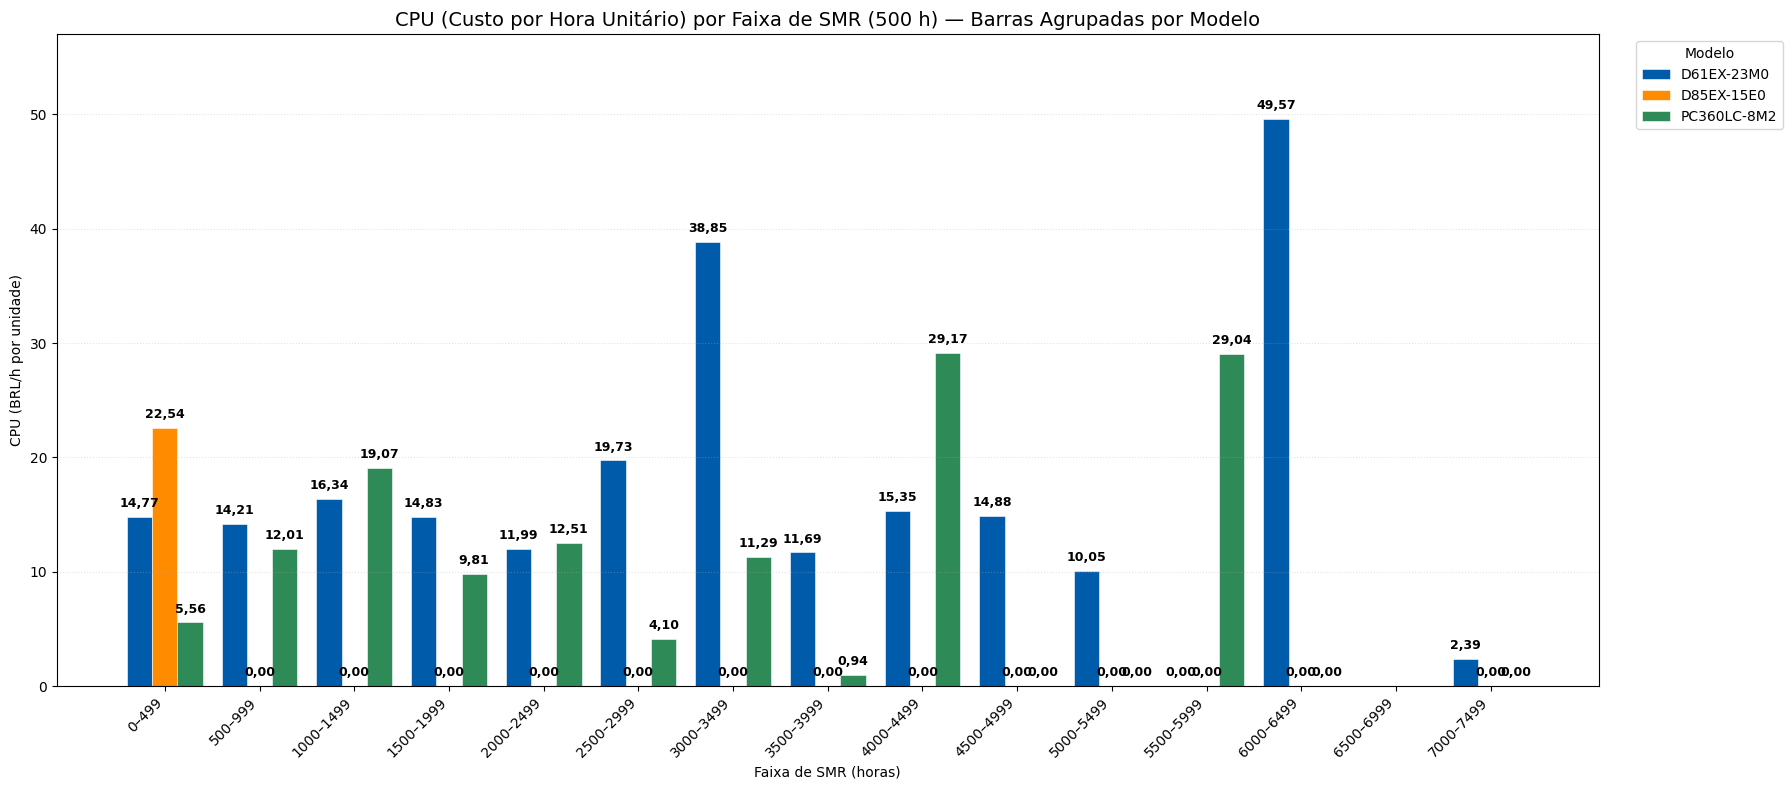

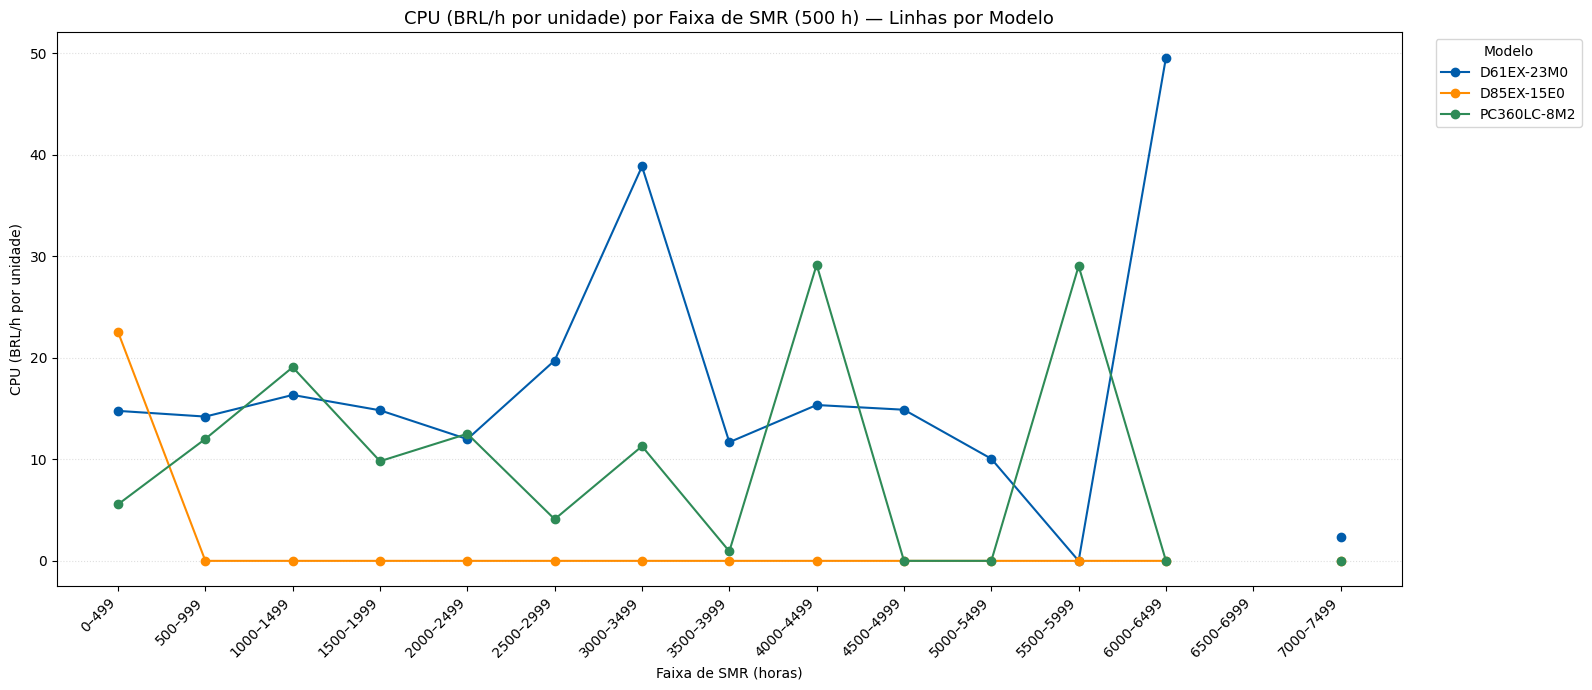

Arquivos gerados:
- cpu_por_faixa_500h_barras_agrupadas_por_modelo.png
- cpu_por_faixa_500h_linhas_por_modelo.png
- cpu_por_faixa_500h_por_modelo.csv


In [3]:

# -*- coding: utf-8 -*-
# Google Colab: CPU (Custo por Hora Unitário) por faixas de SMR (500 h) × modelo
# CPU = Montante / (nº de máquinas únicas na faixa/modelo) / 500 h

# 1) Dependências
!pip -q install openpyxl

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# 2) Fonte de dados (RAW do GitHub)
RAW_URL = "https://raw.githubusercontent.com/CidClayQuirino/WarrantyCostBySMRBomFuturo/2f256b5c40ae944427c31e37c4e530497f38e22a/PC360LC_D85_D61.xlsx"

# 3) Leitura do Excel
df = pd.read_excel(RAW_URL, engine="openpyxl")

# 4) Padronização de nomes (MODEL, SMR, AMOUNT, MCN_SERIAL) com fallback
col_map_candidates = [
    {"MODEL": "MODEL", "SMR": "SMR", "AMOUNT": "AMOUNT", "MCN_SERIAL": "MCN_SERIAL"},
    {"MODEL": "MCN_COMPLETE_MODEL", "SMR": "MCN_FAILURE_SMR", "AMOUNT": "BASE_DEC_TOTAL_AMOUNT", "MCN_SERIAL": "MCN_SERIAL"}
]

def standardize_columns(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        ok = True
        resolved = {}
        for k, v in cand.items():
            if v in df.columns:
                resolved[k] = v
            elif v.lower() in cols_lower:
                resolved[k] = cols_lower[v.lower()]
            else:
                ok = False
                break
        if ok:
            return df[[resolved["MODEL"], resolved["SMR"], resolved["AMOUNT"], resolved["MCN_SERIAL"]]].rename(
                columns={
                    resolved["MODEL"]: "MODEL",
                    resolved["SMR"]: "SMR",
                    resolved["AMOUNT"]: "AMOUNT",
                    resolved["MCN_SERIAL"]: "MCN_SERIAL"
                }
            )
    raise ValueError("Não foi possível localizar colunas MODEL/SMR/AMOUNT/MCN_SERIAL (ou equivalentes).")

df = standardize_columns(df, col_map_candidates)

# 5) Limpeza de tipos
df["MODEL"] = df["MODEL"].astype(str)
df["MCN_SERIAL"] = df["MCN_SERIAL"].astype(str)
df["SMR"] = pd.to_numeric(df["SMR"], errors="coerce")
df["AMOUNT"] = pd.to_numeric(df["AMOUNT"], errors="coerce").fillna(0)

# Remove registros sem SMR
df = df.dropna(subset=["SMR"]).copy()

# 6) Construção das faixas de 500 h até o máximo observado
BIN_SIZE = 500
max_smr = int(np.nanmax(df["SMR"]))
max_edge = int(math.ceil(max_smr / BIN_SIZE) * BIN_SIZE)

bins = np.arange(0, max_edge + BIN_SIZE, BIN_SIZE)       # 0, 500, 1000, ...
labels = [f"{int(bins[i])}–{int(bins[i+1]-1)}" for i in range(len(bins)-1)]

# 7) Atribuir cada registro a uma faixa (categórico com labels)
df["SMR_BIN"] = pd.cut(df["SMR"], bins=bins, right=False, labels=labels)

# 8) Agregar montante total e contar máquinas únicas por faixa × modelo
#    observed=True (silencia FutureWarning e usa apenas grupos observados)
agg_amt = (
    df.groupby(["SMR_BIN", "MODEL"], observed=True, dropna=False)["AMOUNT"]
      .sum()
      .reset_index(name="AMOUNT_SUM")
)
agg_cnt = (
    df.groupby(["SMR_BIN", "MODEL"], observed=True, dropna=False)["MCN_SERIAL"]
      .nunique()
      .reset_index(name="UNIQUE_UNITS")
)

# 9) Merge e cálculo do CPU = AMOUNT_SUM / UNIQUE_UNITS / 500 h
cpu = pd.merge(agg_amt, agg_cnt, on=["SMR_BIN", "MODEL"], how="outer")

# >>> NÃO usar .fillna(0) no DataFrame inteiro (quebraria o categórico SMR_BIN)
# Preencher apenas colunas numéricas:
for col in ["AMOUNT_SUM", "UNIQUE_UNITS"]:
    cpu[col] = pd.to_numeric(cpu[col], errors="coerce").fillna(0)

# Evitar divisão por zero: onde UNIQUE_UNITS == 0, CPU = 0
cpu["CPU_BRPH"] = np.where(cpu["UNIQUE_UNITS"] > 0, cpu["AMOUNT_SUM"] / cpu["UNIQUE_UNITS"] / BIN_SIZE, 0.0)

# 10) Pivot para gráfico (faixa × modelo com valores de CPU)
pivot_cpu = cpu.pivot(index="SMR_BIN", columns="MODEL", values="CPU_BRPH").fillna(0)

# Garantir ordem das faixas (reindex com labels)
pivot_cpu = pivot_cpu.reindex(labels)

# 11) Gráfico de colunas agrupadas (CPU por faixa × modelo) COM RÓTULOS ACIMA DAS BARRAS EM PRETO
plt.figure(figsize=(18, 8))
colors = ['#005CAB','#FF8C00','#2E8B57','#8A2BE2','#DC143C','#1E90FF','#708090','#20B2AA','#8B4513','#FF1493']

x = np.arange(len(pivot_cpu.index))                      # posições das faixas
n_models = max(1, len(pivot_cpu.columns))
bar_width = 0.8 / n_models                               # largura proporcional ao nº de modelos

# Função de formatação BR (ponto para milhar, vírgula para decimal)
def format_number_br(x):
    return f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

# Desenhar barras e capturar containers
bar_containers = []
for i, col in enumerate(pivot_cpu.columns):
    y = pivot_cpu[col].values
    bc = plt.bar(
        x + i*bar_width, y,
        width=bar_width, label=col,
        color=colors[i % len(colors)],
        edgecolor='white', linewidth=0.4
    )
    bar_containers.append(bc)

# Ajuste de margem superior do eixo Y para não cortar os rótulos
max_y = float(np.nanmax(pivot_cpu.values)) if pivot_cpu.size > 0 else 0.0
plt.ylim(0, max_y * 1.15)  # 15% de folga

# Anotar valores SEMPRE acima das barras (cor preta)
dy = 0.6  # deslocamento vertical
for bars in bar_containers:
    for rect in bars:
        h = rect.get_height()
        x_center = rect.get_x() + rect.get_width() / 2.0
        label = format_number_br(h)
        # rótulo acima da barra, preto e levemente negrito
        plt.text(
            x_center, h + dy, label,
            ha='center', va='bottom',
            fontsize=9, color='black', fontweight='bold',
            clip_on=False  # garante que não será cortado pelo eixo
        )

plt.xticks(x + (n_models-1)*bar_width/2, pivot_cpu.index.astype(str), rotation=45, ha='right')
plt.title("CPU (Custo por Hora Unitário) por Faixa de SMR (500 h) — Barras Agrupadas por Modelo", fontsize=14)
plt.xlabel("Faixa de SMR (horas)")
plt.ylabel("CPU (BRL/h por unidade)")
plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis='y', linestyle=':', alpha=0.35)
plt.tight_layout()
plt.savefig("cpu_por_faixa_500h_barras_agrupadas_por_modelo.png", dpi=150)
plt.show()

# 12) (Opcional) Gráfico de linhas — evolução do CPU por modelo ao longo das faixas
plt.figure(figsize=(16, 7))
for i, col in enumerate(pivot_cpu.columns):
    plt.plot(pivot_cpu.index.astype(str), pivot_cpu[col].values,
             marker='o', linestyle='-', color=colors[i % len(colors)], label=col)
plt.xticks(rotation=45, ha='right')
plt.title("CPU (BRL/h por unidade) por Faixa de SMR (500 h) — Linhas por Modelo", fontsize=13)
plt.xlabel("Faixa de SMR (horas)")
plt.ylabel("CPU (BRL/h por unidade)")
plt.grid(True, axis='y', linestyle=':', alpha=0.4)
plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("cpu_por_faixa_500h_linhas_por_modelo.png", dpi=150)
plt.show()

# 13) Exportar CSVs para auditoria/slide
pivot_cpu.to_csv("cpu_por_faixa_500h_por_modelo.csv")
cpu.to_csv("cpu_base_agregada_por_faixa_modelo.csv", index=False)

# 14) Prints organizados (sem strings quebradas)
print("Arquivos gerados:")
print("- cpu_por_faixa_500h_barras_agrupadas_por_modelo.png")
print("- cpu_por_faixa_500h_linhas_por_modelo.png")
print("- cpu_por_faixa_500h_por_modelo.csv")


/tmp/ipython-input-1974559380.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(["SMR_BIN", "MODEL"], dropna=False)["AMOUNT"].sum().reset_index()


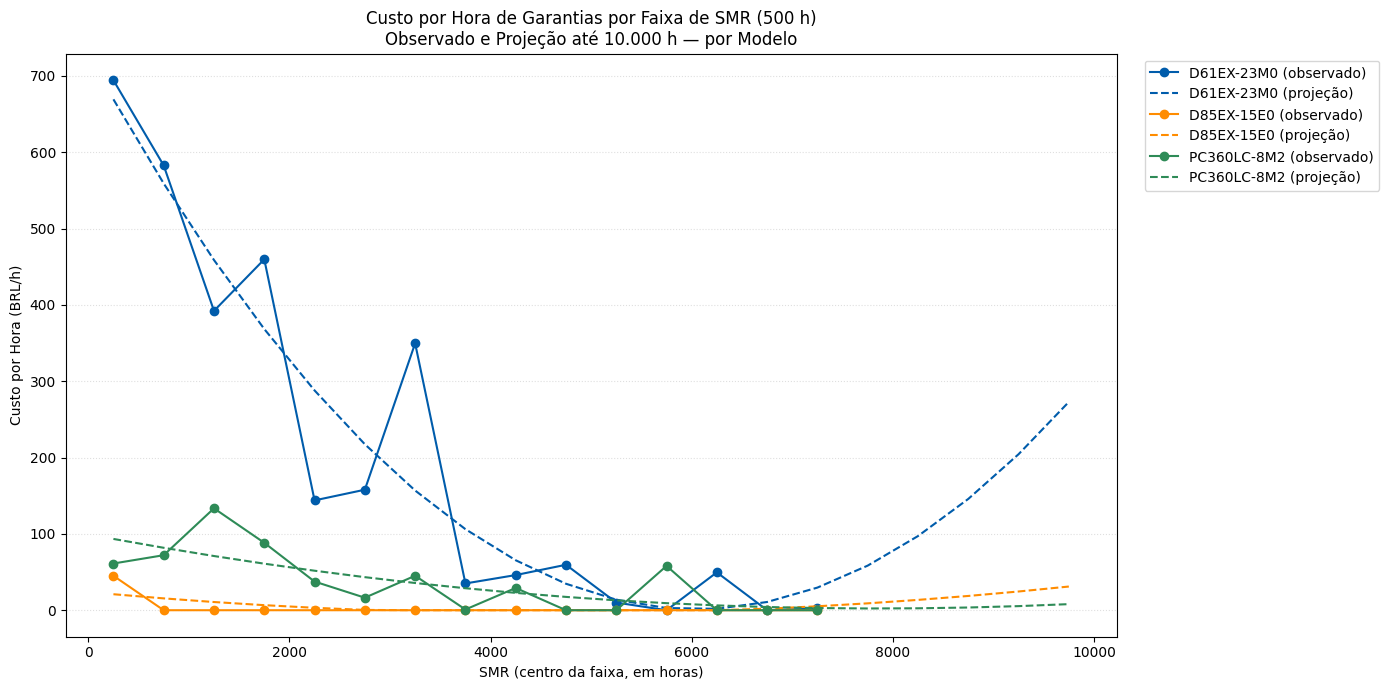

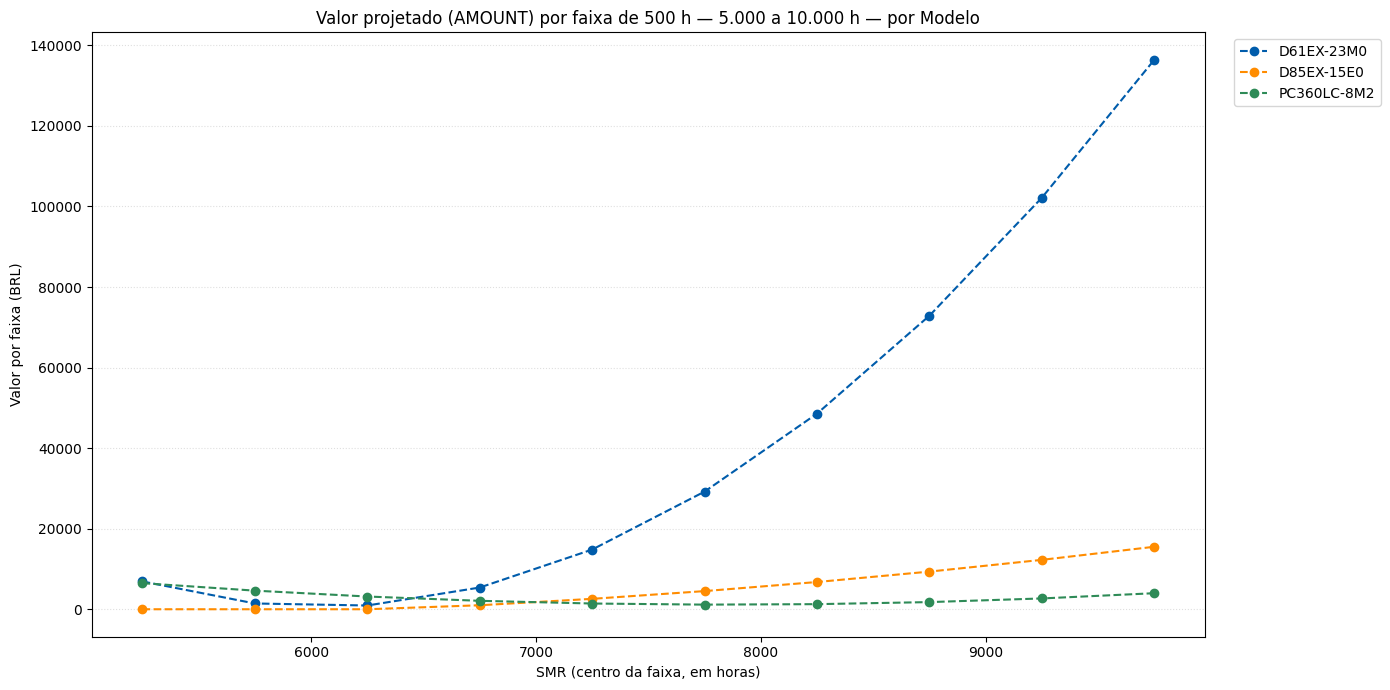

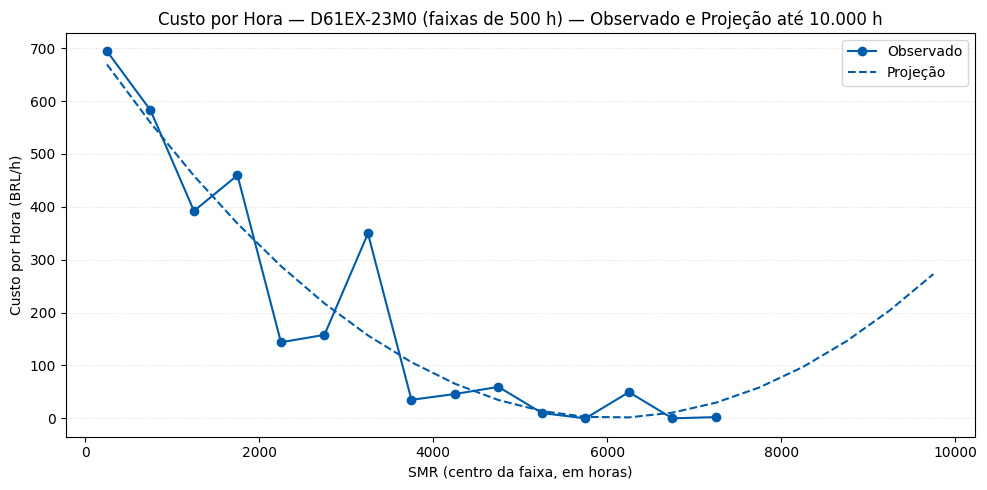

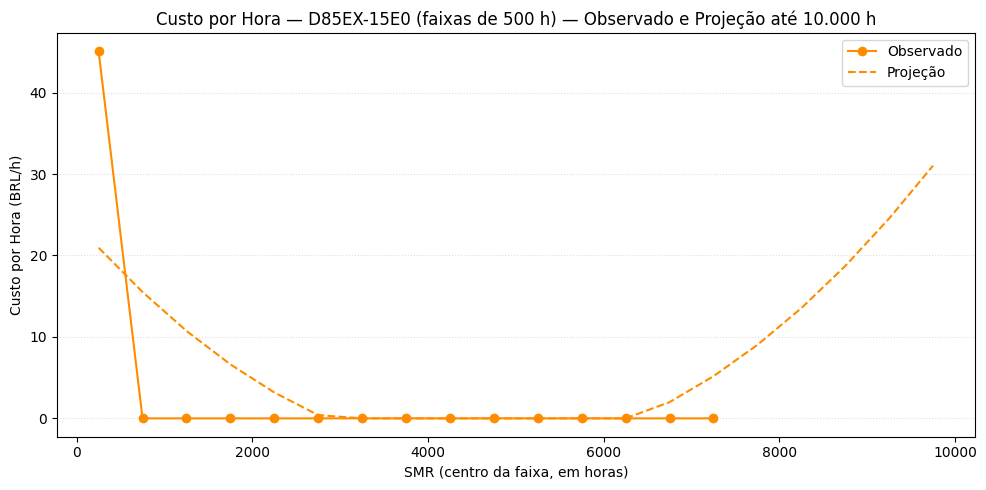

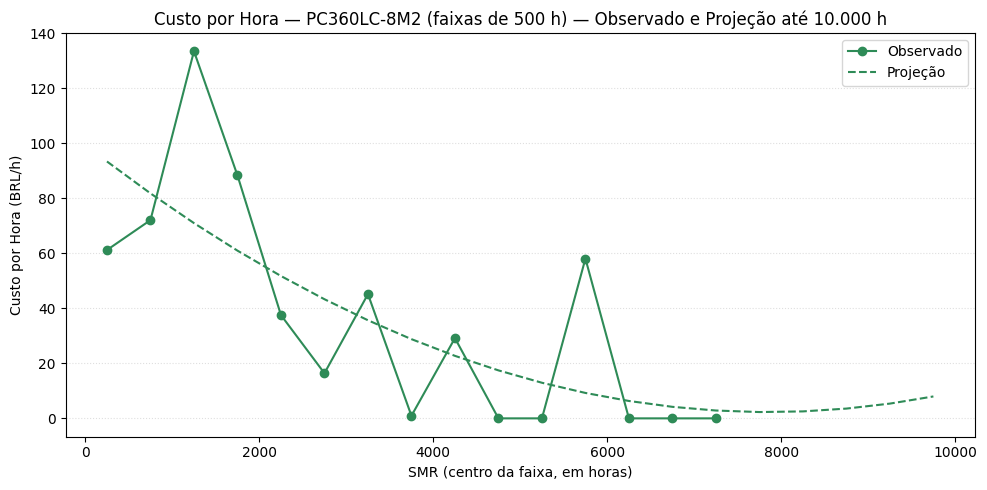


=== TOTAL PROJETADO (AMOUNT) por modelo — 5.000 a 10.000 h ===
D61EX-23M0     418715.517266
D85EX-15E0      51975.210824
PC360LC-8M2     28629.832367


In [2]:

# -*- coding: utf-8 -*-
# Google Colab: cálculo de Custo por Hora de garantias por faixas de SMR (500 h)
# + Projeção da curva até 10.000 h, separado por modelo
# + Conversão da projeção para AMOUNT (valor por faixa) e filtro 5.000–10.000 h

# 1) Dependências
!pip -q install openpyxl

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# 2) Fonte de dados (RAW do GitHub)
RAW_URL = "https://raw.githubusercontent.com/CidClayQuirino/WarrantyCostBySMRBomFuturo/2f256b5c40ae944427c31e37c4e530497f38e22a/PC360LC_D85_D61.xlsx"

# 3) Leitura do Excel
df = pd.read_excel(RAW_URL, engine="openpyxl")

# 4) Padronização de nomes de coluna (MODEL, SMR, AMOUNT)
#    Fallback para nomes usados na sua planilha original (MCN_COMPLETE_MODEL, MCN_FAILURE_SMR, BASE_DEC_TOTAL_AMOUNT)
col_map_candidates = [
    {"MODEL": "MODEL", "SMR": "SMR", "AMOUNT": "AMOUNT"},
    {"MODEL": "MCN_COMPLETE_MODEL", "SMR": "MCN_FAILURE_SMR", "AMOUNT": "BASE_DEC_TOTAL_AMOUNT"}
]

def standardize_columns(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        ok = True
        resolved = {}
        for k, v in cand.items():
            if v in df.columns:
                resolved[k] = v
            elif v.lower() in cols_lower:
                resolved[k] = cols_lower[v.lower()]
            else:
                ok = False
                break
        if ok:
            return df[[resolved["MODEL"], resolved["SMR"], resolved["AMOUNT"]]].rename(
                columns={resolved["MODEL"]: "MODEL", resolved["SMR"]: "SMR", resolved["AMOUNT"]: "AMOUNT"}
            )
    raise ValueError("Não foi possível localizar colunas MODEL/SMR/AMOUNT (ou equivalentes).")

df = standardize_columns(df, col_map_candidates)

# 5) Limpeza de tipos
df["MODEL"] = df["MODEL"].astype(str)
df["SMR"] = pd.to_numeric(df["SMR"], errors="coerce")
df["AMOUNT"] = pd.to_numeric(df["AMOUNT"], errors="coerce").fillna(0)

# Remove registros sem SMR
df = df.dropna(subset=["SMR"]).copy()

# 6) Parâmetros
BIN_SIZE = 500  # tamanho das faixas

# 7) Construção das faixas até o SMR máximo observado
max_smr_observado = int(np.nanmax(df["SMR"]))
max_edge = int(math.ceil(max_smr_observado / BIN_SIZE) * BIN_SIZE)
bins = np.arange(0, max_edge + BIN_SIZE, BIN_SIZE)
labels = [f"{int(bins[i])}–{int(bins[i+1]-1)}" for i in range(len(bins)-1)]

# 8) Atribuição de faixa
df["SMR_BIN"] = pd.cut(df["SMR"], bins=bins, right=False, labels=labels)

# 9) Agregação por faixa e modelo
grp = df.groupby(["SMR_BIN", "MODEL"], dropna=False)["AMOUNT"].sum().reset_index()

# Custo/hora por faixa = total da faixa / 500 h
grp["CUSTO_POR_HORA"] = grp["AMOUNT"] / BIN_SIZE

# 10) Pivot para gráficos (faixa × modelo)
pivot_cph = grp.pivot(index="SMR_BIN", columns="MODEL", values="CUSTO_POR_HORA").fillna(0)
pivot_cph = pivot_cph.reindex(labels)

# 11) Projeção até 10.000 h por modelo (polinômio grau 2, com fallbacks)
def faixa_centers(labels):
    centers = []
    for lab in labels:
        # suporta tanto “–” (en dash) quanto "-" (hyphen) para robustez
        if "–" in lab:
            a, b = lab.split("–")
        else:
            a, b = lab.split("-")
        a, b = int(a), int(b)
        centers.append((a + b) / 2.0)
    return np.array(centers)

centers_observados = faixa_centers(labels)

bins_proj = np.arange(0, 10000 + BIN_SIZE, BIN_SIZE)  # 0, 500, ..., 10000
labels_proj = [f"{int(bins_proj[i])}–{int(bins_proj[i+1]-1)}" for i in range(len(bins_proj)-1)]
centers_proj = faixa_centers(labels_proj)

def prever_por_modelo(y_obs, x_obs, x_proj):
    y = np.array(y_obs, dtype=float)
    x = np.array(x_obs, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)  # corrigido (&) e sem entidades HTML
    x, y = x[mask], y[mask]
    if len(x) == 0:
        return np.zeros_like(x_proj, dtype=float)
    if len(x) == 1:
        yhat = np.full_like(x_proj, y[0], dtype=float)
    elif len(x) == 2:
        coef = np.polyfit(x, y, deg=1)
        yhat = np.polyval(coef, x_proj)
    else:
        coef = np.polyfit(x, y, deg=2)
        yhat = np.polyval(coef, x_proj)
    return np.maximum(yhat, 0.0)  # garante não-negatividade

proj_dict = {}
for modelo in pivot_cph.columns:
    y_obs = pivot_cph[modelo].values
    x_obs = centers_observados[:len(y_obs)]
    proj_dict[modelo] = prever_por_modelo(y_obs, x_obs, centers_proj)

df_proj = pd.DataFrame(proj_dict, index=labels_proj)  # custo/hora projetado
df_proj.index.name = "SMR_BIN"

# ===== 11.1) Converter projeção de CUSTO_POR_HORA -> AMOUNT por faixa (500 h) =====
df_proj_amount = df_proj * BIN_SIZE  # AMOUNT projetado por faixa (BRL por 500 h)
df_proj_amount.index.name = "SMR_BIN"

# Exportar a projeção de AMOUNT para todas as faixas até 10.000 h
df_proj_amount.to_csv("projecao_amount_ate_10000h_por_modelo.csv")

# ===== 11.2) Filtrar apenas faixas de 5.000 a 10.000 h =====
def faixa_inicio(label):
    # rótulo no formato "A–B" ou "A-B"; pega o "A" como início da faixa
    if "–" in label:
        return int(label.split("–")[0])
    return int(label.split("-")[0])

mask_5k_10k = [faixa_inicio(lbl) >= 5000 for lbl in df_proj_amount.index]
amount_5k_10k = df_proj_amount.loc[mask_5k_10k].copy()

# Exportar a projeção de AMOUNT por faixa apenas de 5.000 a 9.999 h
amount_5k_10k.to_csv("projecao_amount_5000_a_10000_por_modelo.csv")

# ===== 11.3) Somatório por modelo no intervalo 5.000–10.000 h =====
totais_5k_10k = amount_5k_10k.sum(axis=0).rename("TOTAL_5k_10k")  # soma das faixas (BRL)
totais_5k_10k.to_csv("total_amount_5000_a_10000_por_modelo.csv")

# 12) Exports originais (custo/hora)
pivot_cph.to_csv("custo_por_hora_por_modelo_por_faixa_500h.csv")
df_proj.to_csv("projecao_custo_por_hora_ate_10000h_por_modelo.csv")

# 13) Gráfico consolidado: Observado + Projeção (Custo por Hora)
plt.figure(figsize=(14, 7))
colors = ['#005CAB', '#FF8C00', '#2E8B57', '#8A2BE2', '#DC143C', '#1E90FF', '#708090', '#20B2AA']

for i, modelo in enumerate(pivot_cph.columns):
    y_obs = pivot_cph[modelo].values
    x_obs = centers_observados[:len(y_obs)]
    plt.plot(x_obs, y_obs, marker='o', linestyle='-', color=colors[i % len(colors)], label=f"{modelo} (observado)")
    yhat = df_proj[modelo].values
    plt.plot(centers_proj, yhat, linestyle='--', color=colors[i % len(colors)], label=f"{modelo} (projeção)")

plt.title("Custo por Hora de Garantias por Faixa de SMR (500 h)\nObservado e Projeção até 10.000 h — por Modelo")
plt.xlabel("SMR (centro da faixa, em horas)")
plt.ylabel("Custo por Hora (BRL/h)")
plt.grid(True, axis='y', linestyle=':', alpha=0.4)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig("custo_por_hora_por_modelo_observado_e_projecao.png", dpi=150)
plt.show()

# 13.b) Gráfico — Valor projetado (AMOUNT) por faixa de 500 h (5k–10k)
plt.figure(figsize=(14, 7))

# coordenadas X para as faixas 5k–10k (centro da faixa)
mask_centers_5k_10k = [faixa_inicio(lbl) >= 5000 for lbl in df_proj_amount.index]
x_5k_10k = centers_proj[mask_centers_5k_10k]

for i, modelo in enumerate(df_proj_amount.columns):
    y_amount = amount_5k_10k[modelo].values  # BRL por faixa (500 h)
    plt.plot(x_5k_10k, y_amount, marker='o', linestyle='--', color=colors[i % len(colors)], label=f"{modelo}")

plt.title("Valor projetado (AMOUNT) por faixa de 500 h — 5.000 a 10.000 h — por Modelo")
plt.xlabel("SMR (centro da faixa, em horas)")
plt.ylabel("Valor por faixa (BRL)")
plt.grid(True, axis='y', linestyle=':', alpha=0.4)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig("amount_projetado_5k_10k_por_modelo.png", dpi=150)
plt.show()

# 14) Um gráfico por modelo (Custo/Hora — observado e projeção), cada PNG separado
for i, modelo in enumerate(pivot_cph.columns):
    plt.figure(figsize=(10, 5))
    y_obs = pivot_cph[modelo].values
    x_obs = centers_observados[:len(y_obs)]
    yhat = df_proj[modelo].values

    plt.plot(x_obs, y_obs, marker='o', linestyle='-', color=colors[i % len(colors)], label="Observado")
    plt.plot(centers_proj, yhat, linestyle='--', color=colors[i % len(colors)], label="Projeção")
    plt.title(f"Custo por Hora — {modelo} (faixas de 500 h) — Observado e Projeção até 10.000 h")
    plt.xlabel("SMR (centro da faixa, em horas)")
    plt.ylabel("Custo por Hora (BRL/h)")
    plt.grid(True, axis='y', linestyle=':', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    # linha corrigida aqui
    plt.savefig(f"custo_por_hora_{modelo.replace('/', '_').replace(' ', '_')}.png", dpi=150)
    plt.show()

# ===== Resumo no console: TOTAL PROJETADO (AMOUNT) 5k–10k =====
print("\n=== TOTAL PROJETADO (AMOUNT) por modelo — 5.000 a 10.000 h ===")
print(totais_5k_10k.sort_values(ascending=False).to_string())
